# Data Preparation<div class='tocSkip'/>

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. For example we frequently use pretty print (`pp.pprint`) instead of `print` and `tqdm`'s `progress_apply` instead of Pandas' `apply`. 

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

You may also find some lines marked with three hashes ###. Those are not in the book as well as they don't contribute to the concept.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [232]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/master'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [233]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append('./packages')

# The Data Set: Reddit Self Posts


## Loading Data into Pandas


In [234]:
import pandas as pd

posts_file = f"{BASE_DIR}/data/rspct_autos.tsv.gz"
posts_df = pd.read_csv(posts_file, sep='\t')

subred_file = "subreddit_info.csv.gz"
subred_file = f"{BASE_DIR}/data/subreddit_info.csv.gz" 
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

df = posts_df.join(subred_df, on='subreddit')
len(df)

20000

## Blueprint: Standardizing Attribute Names


In [235]:
print(df.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


In [236]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',  
    'category_3': None, # no data
    'in_data': None, # not needed
    'reason_for_exclusion': None # not needed
}

# define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# select and rename those columns
df = df[columns].rename(columns=column_mapping)

In [237]:
df.category.value_counts()

autos    20000
Name: category, dtype: int64

In [238]:
df.subcategory.value_counts()

bmw                1000
tesla              1000
ford               1000
saab               1000
trucks             1000
mini               1000
harley davidson    1000
subaru             1000
porsche            1000
volvo              1000
VW                 1000
mazda              1000
jeep               1000
hyundai            1000
toyota             1000
chevrolet          1000
mercedes           1000
lexus              1000
audi               1000
honda              1000
Name: subcategory, dtype: int64

In [239]:
pd.options.display.max_colwidth = None 
df.sample(1).T
pd.options.display.max_colwidth = 200 

,6086
id,64ilth
subreddit,Audi
title,S3 stock vs. A4 with mods (1.8T Quattro)
text,"Greetings!<lb><lb>I'm seeking advice on buying a car. I'm set on the engine, not on the model though. Whatever I buy is going to have AWD and an 1.8T 5V engine. So it's either transverse or longitudinal (S3 or A4).<lb><lb>What do you think about fun-factor? Is the S3 a fun car to drive being a ""normally FWD"" car? On the other hand - how much do I have to do to a stock AEB code engine so that the A4 would be as fast as a stock S3?<lb><lb>S3 (8L, facelift): Pros - Faster, better stock suspension, bigger turbo. Cons - only 3 doors, haldex (not full-time AWD), some say it's a ""girls car""<lb><lb>A4: Pros - Proper full-time AWD, good for trips (would buy an Avant). Cons - lots of mods needed to go fast, it's only ~150hp stock, heavy.<lb><lb>Any input appreciated! Owners are more than welcome to chime in. Cheers!"
category,autos
subcategory,audi


## Saving and Loading a Data Frame


In [240]:
df.to_json("reddit-selfposts.json", orient='records', lines='true')

In [241]:
df.to_csv("reddit-selfposts.csv", sep=";", decimal=".", index=False)

```python
import sqlite3

# write to database
db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df.to_sql("posts", con, index=False, if_exists="replace")
con.close()

# read from database
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()
```

In [242]:
len(df)

20000

# Cleaning Text Data


In [243]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [244]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


## Blueprint: Identify Noise with Regular Expressions


In [245]:
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(impurity(text))

0.09009009009009009


In [246]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
df['impurity'] = df['text'].progress_apply(impurity, min_len=10)

# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)
pd.options.display.max_colwidth = 200 ###

  0%|          | 0/20000 [00:00<?, ?it/s]

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11 months left on the CPO warranty. I asked the deal...,0.21
12357,I'm looking to lease an a4 premium plus automatic with the nav package.<lb><lb>Vehicle Price:<ta...,0.17
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L 4-cylinder<lb><lb>6-speed Manual Transmission<lb>...,0.14


In [247]:
from blueprints.exploration import count_words
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
<lb>,100729
<tab>,642


## Blueprint: Noise Removal with Regular Expressions


In [248]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [249]:
clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [250]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [251]:
df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False) \
                              .head(3)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. Have a Credit score of 780\+ for the best low interest rates! 2. Join a Credit Union to finance the vehicle! 3. Or Find a Lender to finance the vehicle...",0.03
18934,"At the dealership, they offered an option for foot-well illumination, but I cannot find any reference to this online. Has anyone gotten it? How does it look? Anyone have pictures. Not sure if this...",0.03
16505,"I am looking at four Caymans, all are in a similar price range. The major differences are the miles, the years, and one isn’t a S. https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterV...",0.02


## Blueprint: Character Normalization with textacy


In [252]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [253]:
import textacy.preprocessing as tprep

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text
    
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


## Blueprint: Pattern-based Data Masking with textacy


In [254]:
from textacy.preprocessing.resources import RE_URL

count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2


In [255]:
from textacy.preprocessing.replace import urls as replace_urls

text = "Check out https://spacy.io/usage/spacy-101"

# using default substitution _URL_
print(replace_urls(text))

Check out _URL_


In [256]:
df['clean_text'] = df['clean_text'].progress_map(replace_urls)
df['clean_text'] = df['clean_text'].progress_map(normalize)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [257]:
df['text'] = df['title'] + ': ' + df['clean_text']
df = df[['id', 'text', 'subreddit']]

df.to_csv("reddit-selfposts-cleaned.csv", sep=";", decimal=".", index=False)

In [258]:
df

,id,text,subreddit
0,8f73s7,No Club Colors: Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the danc...,Harley
1,5s0q8r,"Roush vs Shleby GT500: I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass sup...",Mustang
2,5z3405,2001 Golf Wagon looking for some insight: Hello! Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... mine's gone out and going to the dealership is quite out of the ra...,Volkswagen
3,7df18v,IS 250 Coolant Flush/Change: _URL_ I have a IS 250 AWD from 2006. About 73K miles on it. I've never touched the engine radiator coolant and can't find anything on when to change this in the book. ...,Lexus
4,5tpve8,"Gen1 mpg w/ dead battery?: Hi, new to this subreddit. I'm considering buying a Gen1 Volt, but I can't find any straight answers as to what kind of mpg it gets after the battery is completely dead ...",volt
...,...,...,...
19995,7i2k6y,"Bilstein Shocks: I read a lot Forums and people recommend getting TUNDRA Bilstein Shocks for a 3rd gen 4 runner, what is the difference? and why do they recommend that? I bought Springs tundra Spr...",4Runner
19996,83p2kv,"Question on potential purchase of crashed bike.: I am thinking about buying a 2010 Harley Sportster 1200 custom for $6k with 7k miles. It has Vance radius pipes, t bars, screaming eagle filters, s...",Harley
19997,7x722h,"Got our first warning light on our dash: My husband and I were headed somewhere and I was cold. So, I figured I could turn the car on before he unplugged it. When it turned on it was fine. Then he...",volt
19998,7v2xmg,"Any IS models to avoid?: I am looking at getting a used Lexus IS (2014 model year and newer). Are there any trim levels that I should avoid? Thinking about getting a 250, however, I might spend a ...",Lexus


# Linguistic Processing with spaCy


## Instantiating a Pipeline


In [56]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [57]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7fbe67c24b80>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7fbe67539ef0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7fbe6757a520>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7fbe67768d00>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7fbe6758eac0>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7fbe675840c0>)]

In [58]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

## Processing Text


In [59]:
nlp = spacy.load("en_core_web_sm")
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [60]:
for token in doc:
    print(token, end="|")

My|best|friend|Ryan|Peters|likes|fancy|adventure|games|.|

In [61]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_, 
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_, 
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [62]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


## Blueprint: Extracting Lemmas based on Part-of-Speech


In [63]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [73]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [83]:
def extract_lemmas(doc, include_pos=None, exclude_pos=[]):
    return [t.lemma_ 
            for t in doc 
            if (include_pos==None or t.pos_ in include_pos) and t.pos_ not in exclude_pos]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


## Blueprint: Extracting Named Entities


In [84]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [85]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [86]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc, 
             include_types=include_types, 
             exclude_types=None, 
             drop_determiners=True, 
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [87]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


# Feature Extraction on a Large Dataset


## Blueprint: One Function to Get It All


In [259]:
def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc, exclude_pos = ['PART', 'PUNCT', 'DET', 'PRON', 'SYM', 'SPACE']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
#    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [260]:
nlp = spacy.load('en_core_web_sm')

In [261]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']


In [262]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'nouns']


## Blueprint: Using spaCy on a Large Data Set


In [263]:
df = pd.read_csv("reddit-selfposts-cleaned.csv", sep=";", decimal=".")

df.sample(3)

,id,text,subreddit
170,5y0lur,Weird stuttering transmission in my 3rd gen.: So I got my 98 limited last week and its been a blast. Went ahead and got the valve cover gasket replaced and fixed 2 misfiring cylinders when I got i...,4Runner
15331,6b0bjx,"Couple of quick questions about exhaust / midpipe: Hello all I have a couple of questions, I have been looking everywhere trying to find what I'm looking for but I'm out of luck.. The first questi...",Mustang
10804,6e7ltz,"TIL: Fuji Heavy Industries hired an anime designer to interpret Eyesight as a transforming robot: You can see a short article here. I am a fan of both the ""Macross"" Japanese anime show and Subaru ...",subaru


In [264]:
for col in nlp_columns:
    df[col] = None

**On Colab**: Choose "Runtime"&rarr;"Change Runtime Type"&rarr;"GPU" to benefit from the GPUs.

In [265]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [267]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# full data set takes about 6-8 minutes
# for faster processing use a sample like this
# df = df.sample(500)

In [268]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
df[['text', 'lemmas', 'nouns']].sample(5)

  0%|          | 0/20000 [00:00<?, ?it/s]

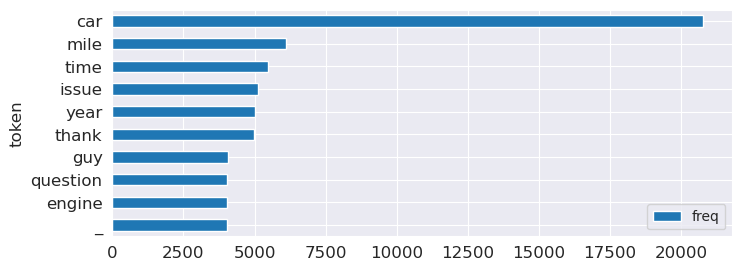

In [269]:
count_words(df, 'nouns').head(10).plot(kind='barh', figsize=(8,3)).invert_yaxis()

## Persisting the Result


In [270]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

df.to_csv("reddit-selfposts-prepared.csv", sep=";", decimal=".", index=False)